## 사전 훈련된 컨브넷 사용하기
* 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것이다.
* **사전 훈련된 네트워크**(pretrained network)는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크이다.
* 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있다.
---
* 사전 훈련된 네트워크를 사용하는 두 가지 방법이 있다.
* **특성 추출**(feature extraction)과 **미세 조정**(fine tuning)이다.

### 특성 추출
* 특성 추출은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것이다.
* 이련 특성을 사용하여 새로운 분류기를 처음부터 훈련한다.
---
* 컨브넷은 이미지 분류를 위해 두 부분으로 구성된다.
* 면저 연속된 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝난다.
* 첫 번째 부분을 모델의 **합성곱 기반 층**(convolutional base)라고 부른다.
* 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기를 훈련한다.
---
* 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하다.
컨브넷의 특성 맵은 사진에 대한 일반적인 콘셉트의 존재 여부를 기록한 맵이다.
* 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있다.
* 분류기는 전췌 사진에 어떤 클래스가 존재할 확률에 관한 정보만 담고 있다.
* 완전 연글 층에서 찾은 표현은 더 이상 입력 이미지에 있는 맥체의 위치 정보를 가지고 있지 않는다.
---
* 특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성) 수준은 모델에 있는 층의 깊이에 달려 있다.
* 모델의 하위 층은 (에지, 색깔, 질감 등) 지역적이고 매우 일반적인 특성 맵을 추출한다.
* 반면에 상위 층은 ('강아지 눈'이나 '고용이 귀'처럼) 좀 더 추상적인 개념을 추출한다.
* 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반 층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋다.

In [1]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

* 최종 특성 맵의 크기는 (4, 4, 512)이다.
* 이 특성 위에 완전 연결 층을 놓을 것이다.
    * 새로운 데이터셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장한다. 그다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용한다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분이다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반 층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 든다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없다.
    * 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장한다. 그다음 입력 데이터에서 엔드-투-엔드로 전체 모델을 실행한다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반 층을 통과하기 때문에 데이터 증식을 사용할 수 있다. 하지만 이런 이유로 이 방식은 첫 번춥 방식보다 훨씬 비용이 많이 든다.

#### 데이터 증식을 사용하지 않는 빠른 특성 추출

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = os.path.join(os.environ['DEV_PATH'], 'datasets/cats_and_dogs_small')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 12ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 11ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 12ms/step


* 추출된 특성의 크기는 (samples, 4, 4, 512)이다.
* 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼친다.

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy', 
    metrics=['acc']
)

history = model.fit(
    train_features, train_labels, 
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Epoch 1/30


c:\Users\posky\anaconda3\envs\tf20\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - 1s 5ms/step - loss: 0.5978 - acc: 0.6725 - val_loss: 0.4418 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4315 - acc: 0.8085 - val_loss: 0.3554 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3610 - acc: 0.8445 - val_loss: 0.3178 - val_acc: 0.8810
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3102 - acc: 0.8745 - val_loss: 0.2953 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2771 - acc: 0.8840 - val_loss: 0.2775 - val_acc: 0.8950
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2545 - acc: 0.9010 - val_loss: 0.2657 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2421 - acc: 0.9035 - val_loss: 0.2721 - val_acc: 0.8900
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2318 - acc:

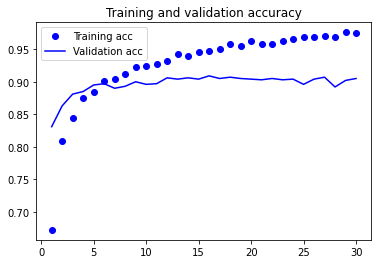

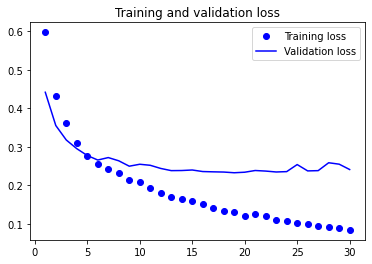

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 데이터 증식을 사용한 특성 추출

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


* 모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 동결하는 것이 아주 중요하다. 하나 이성의 층을 **동결**(freezing)한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻이다.
* 맨 위의 Dense 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것이다.
* 이는 사전에 학습된 표현을 크게 훼손하게 된다.

In [12]:
print('number of weights before freezing conv_base:', len(model.trainable_weights))
conv_base.trainable = False
print('number of weights after freezing conv_base:', len(model.trainable_weights))

number of weights before freezing conv_base: 30
number of weights after freezing conv_base: 4


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


C:\Users\posky\AppData\Local\Temp\ipykernel_12668\1257896320.py:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 9s - loss: 0.5614 - acc: 0.7310 - val_loss: 0.4367 - val_acc: 0.8370 - 9s/epoch - 89ms/step
Epoch 2/30
100/100 - 8s - loss: 0.4178 - acc: 0.8245 - val_loss: 0.3735 - val_acc: 0.8500 - 8s/epoch - 82ms/step
Epoch 3/30
100/100 - 8s - loss: 0.3601 - acc: 0.8505 - val_loss: 0.3162 - val_acc: 0.8630 - 8s/epoch - 82ms/step
Epoch 4/30
100/100 - 9s - loss: 0.3203 - acc: 0.8720 - val_loss: 0.3022 - val_acc: 0.8630 - 9s/epoch - 87ms/step
Epoch 5/30
100/100 - 8s - loss: 0.3060 - acc: 0.8790 - val_loss: 0.2825 - val_acc: 0.8770 - 8s/epoch - 84ms/step
Epoch 6/30
100/100 - 8s - loss: 0.2917 - acc: 0.8855 - val_loss: 0.2626 - val_acc: 0.8960 - 8s/epoch - 83ms/step
Epoch 7/30
100/100 - 8s - loss: 0.2730 - acc: 0.8925 - val_loss: 0.2605 - val_acc: 0.8960 - 8s/epoch - 84ms/step
Epoch 8/30
100/100 - 8s - loss: 0.2678 - acc: 0.8970 - val_loss: 0.2525 - val_acc: 0.8930 - 8s/epoch - 83ms/step
Epoch 9/30
100/100 - 8s - loss: 0.2625 - acc: 0.8965 - val_loss: 0.2457 - val_acc: 0.9000 - 8s/epoch - 83ms

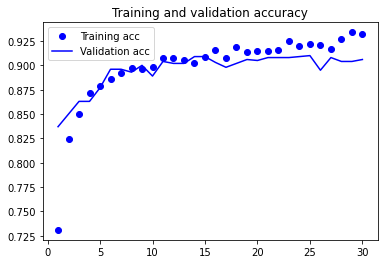

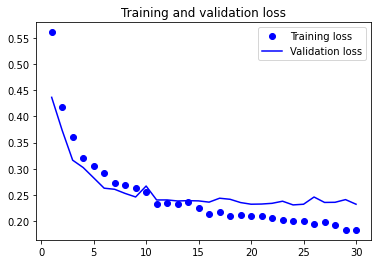

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 미세 조정
* 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 **미세 조정**(fine-tuning)이다.
* 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델이 새로 추가흔 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것이다.
---
* 랜덤하게 초기화된 상단 분류기를 훈련하기 위해 VGG16의 합성곱 기반 층을 동결해야 한다고 했었다.
* 같은 이유로 맨 위에 있는 분류기가 훈련된 후에 합성곱 기반의 상위 층을 미세조정할 수 있다.
* 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 천파된다.
* 이는 미세 조정될 층들이 사전에 학습한 표현들을 망가뜨리게 된다.
* 네트워크를 미세 조정하는 단계.
    1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가한다.
    2. 기반 네트워크를 동결한다.
    3. 새로 추가한 네트워크를 훈련한다.
    4. 기반 네트워크에서 일부 층의 둥결을 해제한다.
    5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련한다.

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

* 합성곱 기반 층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩한다. 반면에 상위 층은 좀 더 특화된 특성을 인코딩한다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리하다. 하위 층으로 갈수록 미세 조정에 대한 효과가 감소한다.
* 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커진다. 합성곱 기반 층은 1,500만 개의 파라미터를 가지고 있다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험하다.

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

* 학습률을 낮춘 RMSProp 옵티마이저를 사용한다.
* 학습률을 낮추는 이유는 개세 조정하는 3개의 층에서 학습된 표현을 조금씩 수정하기 위해서.
* 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있다.

In [18]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100


c:\Users\posky\anaconda3\envs\tf20\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
C:\Users\posky\AppData\Local\Temp\ipykernel_12668\1394018152.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 10s 89ms/step - loss: 0.1970 - acc: 0.9170 - val_loss: 0.2222 - val_acc: 0.9160
Epoch 2/100
100/100 [==============================] - 9s 85ms/step - loss: 0.1577 - acc: 0.9360 - val_loss: 0.2494 - val_acc: 0.9080
Epoch 3/100
100/100 [==============================] - 9s 86ms/step - loss: 0.1346 - acc: 0.9460 - val_loss: 0.2256 - val_acc: 0.9120
Epoch 4/100
100/100 [==============================] - 9s 86ms/step - loss: 0.1240 - acc: 0.9520 - val_loss: 0.2331 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 9s 86ms/step - loss: 0.1125 - acc: 0.9585 - val_loss: 0.2110 - val_acc: 0.9180
Epoch 6/100
100/100 [==============================] - 9s 86ms/step - loss: 0.0954 - acc: 0.9655 - val_loss: 0.2315 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 9s 86ms/step - loss: 0.0890 - acc: 0.9635 - val_loss: 0.2126 - val_acc: 0.9240
Epoch 8/100
100/100 [==============================] - 9s 86ms/step - los

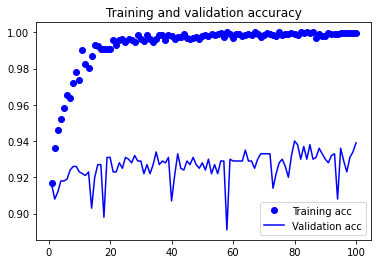

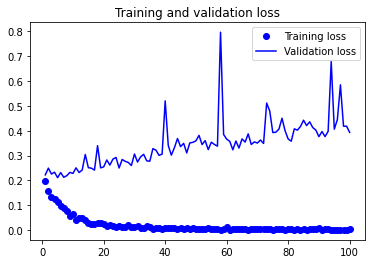

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 그래프가 불규칙하게 보인다.
* 그래프를 보기 쉽게 하기 위해 **지수 이동 평균**(exponential moving averages)으로 정확도와 손실 값을 부드럽게 표현할 수 있다.

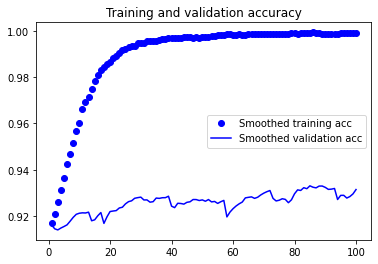

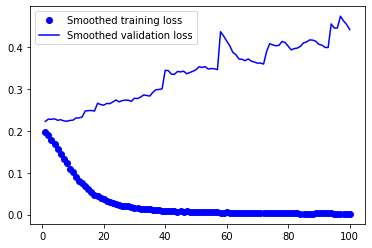

In [20]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.legend()

plt.show()

* 그래프는 개별적인 손실 값의 평균을 그린 것이다.
* 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아니다.
* 정확도는 모델이 예측한 클래스 확률이 어떤 임계 값을 넘었는지에 대한 결과이기 때문이다.
* 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있다.

In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\posky\AppData\Local\Temp\ipykernel_12668\3847350361.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9359999895095825


### 정리
* 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델이다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있다.
* 적은 데이터셋에서는 과대적합이 큰 문제이다. 데이터 증식은 이미지 데이터를 다룰 때 과대적합을 막을 수 있는 강력한 방법이다.
* 특성 추출 방식으로 새로운 데이터셋에 기존 컨브넷을 쉽게 재사용할 수 있다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법이다.
* 특성 추출을 보완하기 위해 기세 조정을 사용할 수 있다. 미게 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킨다. 이 기법은 조금 더 성능을 끌어올린다.